# sigma0 cross-track sensitivity


Expected cross-track sensitivity (BC):

$
\begin{align}
\sigma_0 &\propto 1/mss \times \exp ( -\tan^2 (\theta) /mss), \\
\end{align}
$

which implies:

$
\begin{align}
\log(\sigma_0(\theta=0)) &\propto \log(1/mss) \\
\log(\sigma_0) &\propto \log(\sigma_0(0)) - \tan^2 (\theta) \times 1/mss, \\
\sigma_0/\sigma_{0} &\propto \exp ( -\tan^2 (\theta) /mss), \\
\log \sigma_0/\sigma_0(0) &\propto -(\tan^2 (\theta) \times \sigma_0(0), \\
\frac{\log (\sigma_0/\sigma_0(0))}{\sigma_0(0)} &\propto -\tan^2 (\theta), \\
mss &= 5\times10^{-3} \times u10
\end{align}
$




**Pierre D.**
    
Boisot et al. 2015, equation 8:

$
\begin{align}
\sigma^0 = \frac{|R|^2}{mss} \sec^4 (\theta) \exp \Big ( - \frac{\tan^2 \theta }{mss}  \Big )
\end{align}
$

$
\begin{align}
mss^3 \frac{\sigma_0}{R^2} \cos \theta - mss^2 + mss \tan^2 \theta - \frac{1}{2}\tan^4 \theta = 0
\end{align}
$

```
Pour l'application de la fonction sig0 Nadir, ca dépend vraiment de ce que tu veux faire. En l'état ca permet d'enlever la dépendance en incidence du sigma0, en faisant le choix d'une valeur absolue qui corresponde à une visée Nadir. (Si ta question est une question software, oui, il faut boucler la fonction sig0Nadir(ds,i,j) avec i et j les index des lignes et colonnes qui t'interessent)
Pour l'altitude moyenne tu peux prendre 890.582km si tu regardes la donnée de l'orbite science (21j) https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit/science-orbit.html. Pour l'orbite à 1j c'est 857.244km.
J'utilise un modèle Geometric Optical* omnidirectionnel** (par exemple equation (8) de https://oboisot.com/medias/publis/Boisot_TGRS15.pdf) L'idée c'est d'estimer le paramètre mss en connaissant R²=0.56, theta et sigma0(theta). Puis d'appliquer (8) avec R²=0.56, mss_estimé et theta=0 pour se ramener à un sigma0 équivalent Nadir.

N'hésite pas à me relancer pour des précisions.
Pierre

* ce modèle radiométrique simple peut est considéré comme "plutôt bon" pour les angles de visé de SWOT. Il en existe des meilleurs mais qui vont grandement compliquer l'estimation des paramètres (et pouvoir in-fine appliquer le même modèle en theta = 0)

** on ne dépend pas de la direction relative du vent. Là encore on pourrait faire mieux au prix d'une complexification de l'inversion, si on connait a priori la direction du vent (laquelle? modèle ? donnée ?) Le gain pour un detrending  de sigma0 pour des incidences <6deg n'est probablement pas suffisant par rapport aux erreurs qu'apporterait un vent modèle ou au bruit/biais qu'apporterait un vent données.
```

In [1]:
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import datetime

import matplotlib.pyplot as plt
import cartopy
crs = cartopy.crs.PlateCarree()
import cartopy.feature as cfeature

import hvplot.xarray
import hvplot.pandas

#import pyinterp

#import dask_jobqueue
#import dask
#from distributed import Client

sys.path.append("/work/HELPDESK_SWOTLR/swot_diego/libs")
import swot_diego as sd

---

## theoretical sensitivity

In [8]:
R2 = 0.56
sig0 = lambda mss, theta: R2/mss /np.cos(theta)**4 * np.exp(-np.tan(theta)**2/mss)

In [32]:
theta = np.linspace(.6,4.1,50)
u10 = np.linspace(1,10,50)
ds = xr.Dataset(None, 
    coords=dict(u10=('u10', u10),
                theta=('theta', theta),
               )
)
ds["mss"] = 5e-3 * ds.u10
ds["_theta"] = np.deg2rad(ds.theta) # rad
ds["tan_theta"] = np.tan(ds._theta)
ds["cos_theta"] = np.cos(ds._theta)
ds["sig0"] = sig0(ds.mss, ds._theta)
ds["exp"] = np.exp(-ds.tan_theta**2/ds.mss)
ds = ds.set_coords(["tan_theta"])

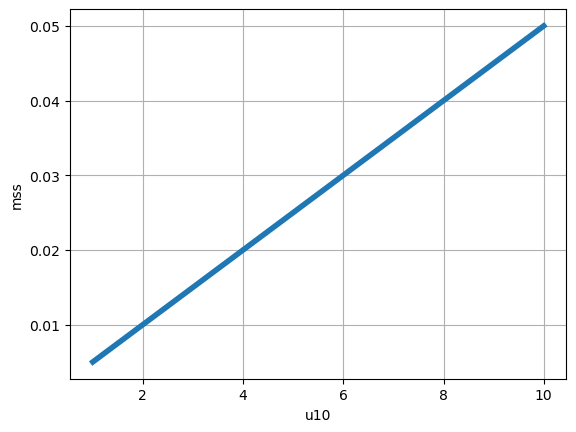

In [23]:
fig, ax = plt.subplots(1,1)
ds.mss.plot(lw=4)
ax.grid()

Text(0.5, 1.0, 'sigma0')

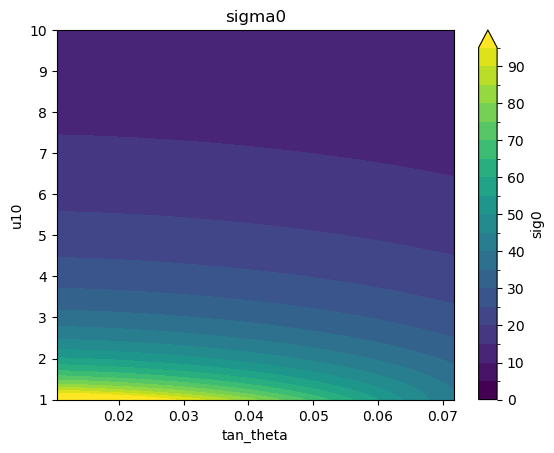

In [22]:
fig, ax = plt.subplots(1,1)
ds["sig0"].plot.contourf(x="tan_theta", y="u10", ax=ax, levels=np.arange(0,100,5))
ax.set_title("sigma0")
#ax.set_yscale("log")

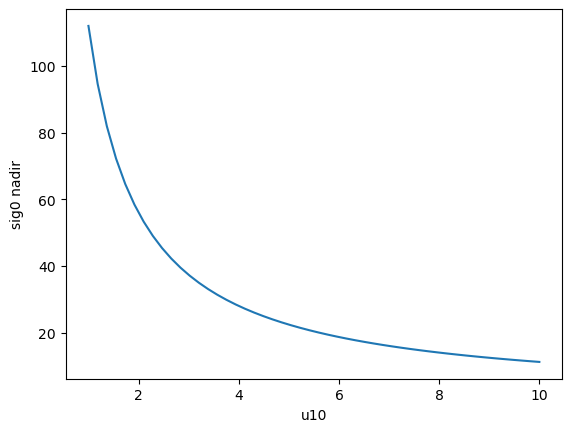

In [12]:
sig0(ds.mss, 0).rename("sig0 nadir").plot()

(0.0, 114.56335726015311)

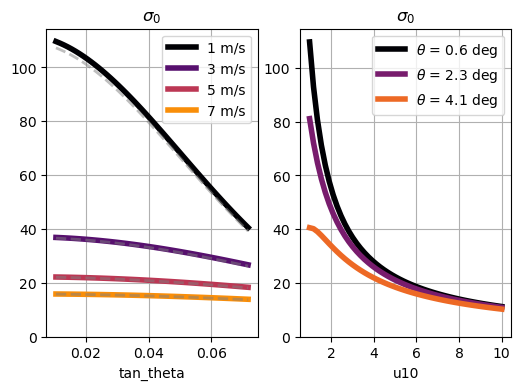

In [51]:
fig, axes = plt.subplots(1,2, figsize=(6,4))

ax = axes[0]
_lvls = [1, 3, 5, 7]
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for u10, c in zip(_lvls, colors):
    _ds = ds.sel(u10=u10, method="nearest")
    _ds["sig0"].plot(x="tan_theta", ax=ax, color=c, lw=4, label=f"{u10} m/s")
    (float(_ds["sig0"][0])*_ds["exp"]).plot(x="tan_theta", ax=ax, color="0.5", alpha=0.5, lw=2, ls='--')
ax.grid()
ax.set_title(r"$\sigma_0$")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)
#ds["sig0"].plot.contourf(ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
#ax.set_yscale("log")


ax = axes[1]

_lvls = np.linspace(ds.theta.min(), ds.theta.max(), 3)
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for t, c in zip(_lvls, colors):
    _ds = ds.sel(theta=t, method="nearest")
    _ds["sig0"].plot(ax=ax, color=c, lw=4, label=r"$\theta$ = "+f"{t:.1f} deg")
    #(float(_ds["sig0"])*_ds["exp"]).plot(ax=ax, color="0.5", alpha=0.5, lw=2, ls='--')
ax.grid()
ax.set_title(r"$\sigma_0$")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)

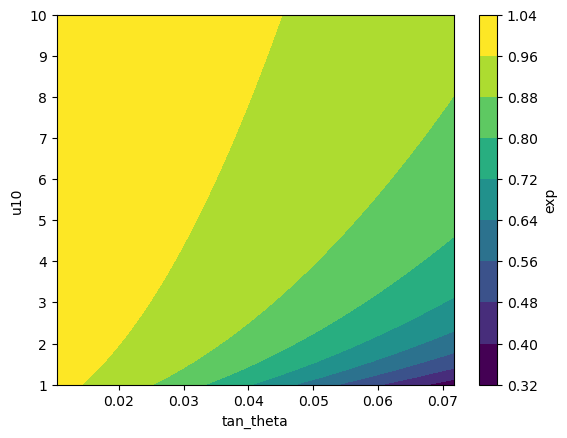

In [27]:
ds["exp"].plot.contourf(x="tan_theta", levels=10)

(0.0, 1.0288507758289216)

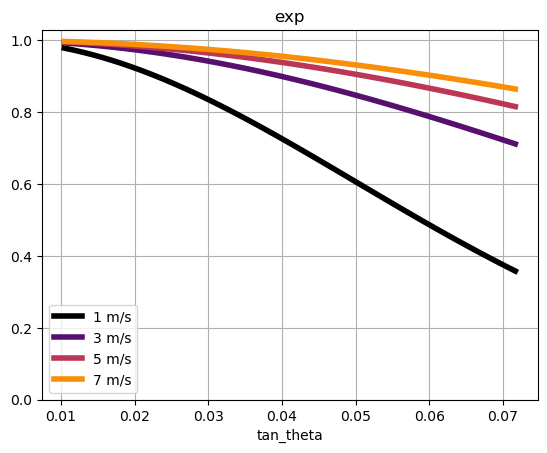

In [28]:
fig, ax = plt.subplots(1,1)

_lvls = [1, 3, 5, 7]
colors = plt.cm.inferno(np.linspace(0,1,len(_lvls)+1))
for u10, c in zip(_lvls, colors):
    _ds = ds.sel(u10=u10, method="nearest")
    _ds["exp"].plot(x="tan_theta", ax=ax, color=c, lw=4, label=f"{u10} m/s")
ax.grid()
ax.set_title("exp")
ax.legend()
ax.set_ylabel("")
ax.set_ylim(0,None)
#ds["sig0"].plot.contourf(ax=ax, levels=np.array([0, 20, 40, 60, 80, 100, 150, 200]))
#ax.set_yscale("log")

---

## observed sensitivity ... could be improved

In [56]:
cycle_number = 501
pass_number = 20

D = sd.load_l2_std("Unsmoothed", pass_number, cycle_number, s0_rescale=False)

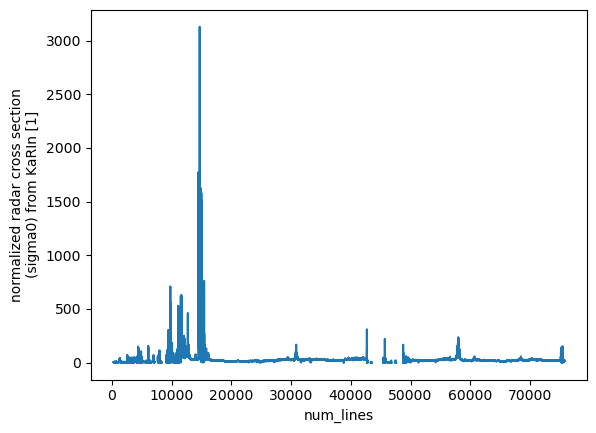

In [59]:
da = D["left"]["sig0_karin_2"]
da.isel(num_pixels=10).plot()

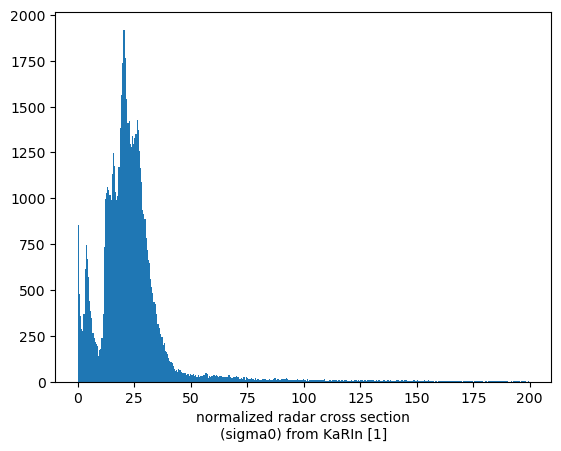

In [61]:
da.isel(num_pixels=10).plot.hist(bins=np.arange(0,200,.5));

In [73]:
#fig, ax = plt.subplots(1,1)
#(da/da.isel(num_pixels=20)).isel(num_lines=slice(10_000, 11_000)).plot(vmin=0,vmax=10)
#ax.set_aspect("equal")

In [45]:
# .6 to 4
np.tan(np.deg2rad(4))**2

0.00488975902858307

/work/HELPDESK_SWOTLR/commun/envs/py311_dev/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


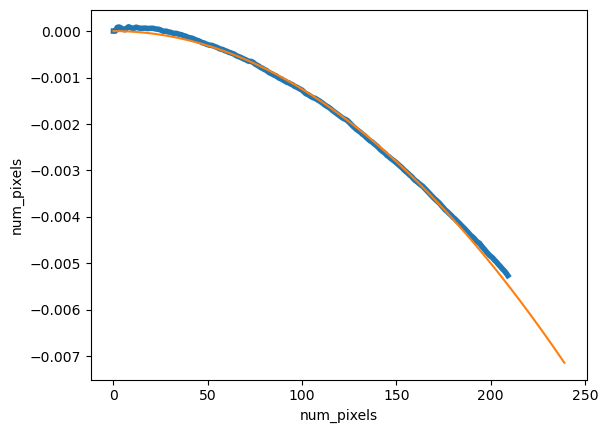

In [74]:
s0 = da
s00 = da.isel(num_pixels=10)
fig, ax = plt.subplots(1,1)
(np.log10(s0/s00)/s00).median("num_lines")[10:220].plot(ax=ax, lw=4)
(-5e-3*(da.num_pixels/200)**2).plot(ax=ax)

In [ ]:
ds = D["left"]

from scipy.optimize import least_squares

i = 200
_ds = ds.isel(num_lines=i)
sig0 = _ds.sig0_karin_2.values
tan_theta = _ds.tan_theta.values
#sig0, tan_theta

# get rid of nans
tan_theta = tan_theta[np.where(~np.isnan(sig0))]
sig0 = sig0[np.where(~np.isnan(sig0))]

def fun(x):
    # sig0 = cst / mss * exp(-tan_theta**2/mss)
    # x = [cst, ]
    return sig0 - fun_sig0(x[0], x[1])

def fun_sig0(cst, mss):
    return cst/mss*np.exp(-tan_theta**2/mss)

mss0 = 0.04
x0 = np.array([sig0[0]*mss0*np.exp(tan_theta[0]**2/mss0), mss0])
print(x0)

# https://scipy-cookbook.readthedocs.io/items/robust_regression.html
res_robust = least_squares(fun, x0, loss='soft_l1')    
cst, mss = res_robust["x"] # cst, mss

fig, ax = plt.subplots(1,1)
ax.plot(sig0)
ax.plot(fun_sig0(cst, mss))
ax.set_title(f"sig0, mss={mss:.2e}, cst={cst:.2e}")

def fit_mss(sig0, tan_theta):

    # get rid of nans
    tan_theta = tan_theta[np.where(~np.isnan(sig0))]
    sig0 = sig0[np.where(~np.isnan(sig0))]
    if sig0.size==0:
        return 0

    def fun(x):
        # sig0 = cst / mss * exp(-tan_theta**2/mss)
        # x = [cst, ]
        return sig0 - fun_sig0(x[0], x[1])

    def fun_sig0(cst, mss):
        return cst/mss*np.exp(-tan_theta**2/mss)

    mss0 = 0.04
    x0 = np.array([sig0[0]*mss0*np.exp(tan_theta[0]**2/mss0), mss0])

    # https://scipy-cookbook.readthedocs.io/items/robust_regression.html
    res_robust = least_squares(fun, x0, loss='soft_l1')    
    cst, mss = res_robust["x"] # cst, mss
    
    return mss
    
da = xr.apply_ufunc(
    fit_mss, ds.sig0_karin_2_low, ds.tan_theta, 
    input_core_dims=[("num_pixels",), ("num_pixels",)], 
    vectorize=True,
)

---

In [ ]:
client.close()
cluster.close()